In [2]:
!pip install qiskit
!pip install qiskit_aer
!pip install qiskit_ibm_runtime
!pip install pylatexenc
!pip install qiskit-algorithms
!pip install qiskit_finance
!pip install qiskit_optimization
!pip install QiskitFinanceError

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 11.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 24.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 7.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requireme

In [12]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
from qiskit_aer import Aer
#from qiskit.utils import QuantumInstance
from qiskit_algorithms.utils import algorithm_globals
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms import VQE, QAOA
from qiskit.circuit.library import TwoLocal
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_finance.data_providers import RandomDataProvider
from qiskit.primitives import Estimator
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import SamplingMinimumEigensolver
from qiskit.primitives import Sampler


In [17]:
# Set parameters
num_assets = 3  # number of assets
q = 0.5  # risk factor
budget = 2  # budget to select exactly 2 out of 3 assets
seed = 123  # random seed

# Generate random data for assets
stocks = [("STOCK%s" % i) for i in range(3)]
#stocks = stocks+ stocks + stocks
print(stocks)

['STOCK0', 'STOCK1', 'STOCK2']


In [18]:

data = RandomDataProvider(
    tickers=stocks,
    start=datetime.datetime(2016, 1, 1),
    end=datetime.datetime(2016, 1, 30),
    seed=seed,
)
data.run()


[ 0.01528439 -0.00078095  0.00051792]
[[2.54138859e-03 7.34022167e-05 1.28600531e-04]
 [7.34022167e-05 2.58486713e-04 5.30427595e-05]
 [1.28600531e-04 5.30427595e-05 7.91504681e-04]]
3
3


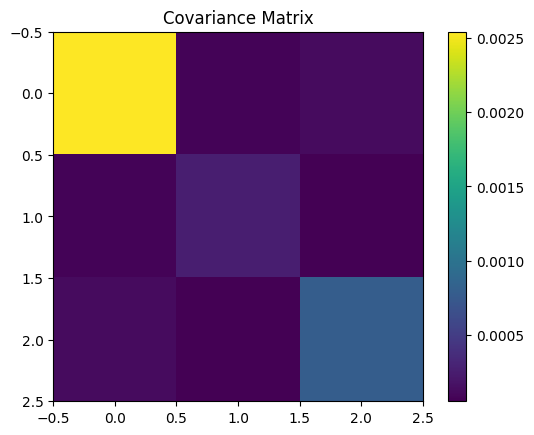

In [19]:

# Get the expected return vector and covariance matrix
mu = data.get_period_return_mean_vector()
sigma = data.get_period_return_covariance_matrix()
#mu = np.append(mu,np.append(mu,mu))
print(mu)
print(sigma)
"""
sigma = np.array([
      np.append(sigma[0],np.append(sigma[0],sigma[0])),
      np.append(sigma[1],np.append(sigma[1],sigma[1])),
      np.append(sigma[2],np.append(sigma[2],sigma[2])),
      np.append(sigma[0],np.append(sigma[0],sigma[0])),
      np.append(sigma[1],np.append(sigma[1],sigma[1])),
      np.append(sigma[2],np.append(sigma[2],sigma[2])),
      np.append(sigma[0],np.append(sigma[0],sigma[0])),
      np.append(sigma[1],np.append(sigma[1],sigma[1])),
      np.append(sigma[2],np.append(sigma[2],sigma[2]))

])
"""
print(len(mu))
print(len(sigma[0]))
# Visualize the covariance matrix
plt.imshow(sigma, interpolation='nearest')
plt.colorbar()
plt.title("Covariance Matrix")
plt.show()

In [21]:

# Define Portfolio Optimization Problem

bounds = [(0,1),(0,1),(0,1)]

portfolio = PortfolioOptimization(expected_returns=mu, covariances=sigma, risk_factor=q, budget=budget, bounds=bounds)
qp = portfolio.to_quadratic_program()
print(qp)

# Define the VQE Solver
algorithm_globals.random_seed = seed
cobyla = COBYLA(maxiter=100)
ry = TwoLocal(num_assets, "ry", "cz", reps=3, entanglement="full")
#quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=1024, seed_simulator=seed, seed_transpiler=seed)
estimator = Estimator()
sampler = Sampler()

# Perform VQE
vqe = VQE(estimator=estimator, ansatz=ry, optimizer=cobyla)

qaoa= QAOA(sampler = sampler,optimizer=cobyla)

vqe_solver = MinimumEigenOptimizer(qaoa)

# Solve the problem
result = vqe_solver.solve(qp)
print(result)

# Print the optimized portfolio
selection = [stocks[i] for i in range(num_assets) if result.x[i] > 0.5]
print("Optimized Portfolio:", selection)

minimize 0.001270694296030004*x_0^2 + 7.34022166934733e-05*x_0*x_1 + 0.00012860053085450988*x_0*x_2 + 0.00012924335651113268*x_1^2 + 5.304275948260219e-05*x_1*x_2 + 0.0003957523406615203*x_2^2 - 0.015284386651719337*x_0 + 0.0007809521451492393*x_1 - 0.0005179205467023194*x_2 (3 variables, 1 constraints, 'Portfolio optimization')
fval=-0.014007260030875622, x_0=1.0, x_1=0.0, x_2=1.0, status=SUCCESS
Optimized Portfolio: ['STOCK0', 'STOCK2']


In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, Session
from qiskit_ibm_runtime import SamplerV2 as Sampler_IBM


api_key = "8216c5b97681d7c958128f2f82a0103e1d80bf509f724fd09b5a5e69c8d56e62237f741c44dbef17bb9ef0bc08e56bd23c2ec85ad4bec6dc9c5737f667488fc3"

service = QiskitRuntimeService(channel="ibm_quantum", # ibm_cloud
                               token = api_key)
backend = service.backend(name = "ibm_sherbrooke")

session = Session(backend=backend)

sampler = Sampler_IBM(backend, options={"default_shots": 4096})


cobyla = COBYLA()
cobyla.set_options(maxiter=1000)
qaoa= QAOA(sampler = sampler,optimizer=cobyla)


vqe_solver = MinimumEigenOptimizer(qaoa)

# Solve the problem
result = vqe_solver.solve(qp)
print(result)

# Print the optimized portfolio
selection = [stocks[i] for i in range(num_assets) if result.x[i] > 0.5]
print("Optimized Portfolio:", selection)

<ipython-input-26-ebcb1a6749f8>:15: DeprecationWarning: The Sampler and Estimator V1 primitives have been deprecated as of qiskit-ibm-runtime 0.23.0 and will be removed no sooner than 3 months after the release date. Please use the V2 Primitives. See the `V2 migration guide <https://docs.quantum.ibm.com/api/migration-guides/v2-primitives>`_. for more details
  sampler = Sampler_IBM(backend, options={"default_shots": 4096})


IBMInputValueError: 'The instruction h on qubits (0,) is not supported by the target system. Circuits that do not match the target hardware definition are no longer supported after March 4, 2024. See the transpilation documentation (https://docs.quantum.ibm.com/transpile) for instructions to transform circuits and the primitive examples (https://docs.quantum.ibm.com/run/primitives-examples) to see this coupled with operator transformations.'